### Implementing coupled word2vec idea

For this implementation which is specific for the directed graph, we take one node before and one node after a specific node. For example lets assume we have a walk from i to j to k. In our case, this means that i has emmited and j has received a signal. Then j has emitted and k has received a signal. We will try to reconstruct two embeddings, one for emitters and one for receivers and we call them E and R correspondingly. In this implementation, we will give j as input and will try to predict i on one arm of the machine and k on another arm. Then in the loss function we will try to minimize the distance between the emmitor representation of i and receiver representation of j as well as the distance between emmitor representation of j and receivor representation of k.

In [1]:
import warnings; warnings.simplefilter('ignore')

import torch
import os
import time
import itertools
import torch.nn as nn
from cell import graph_utils, utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph


os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import imp
from cell import  utils, analysis, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [3]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    
    
def build_data_loader(datasets, batch_size, shuffle=True, drop_last=True, num_workers=1):
    data_loader = torch.utils.data.DataLoader(
        ConcatDataset(*[datasets[k][0] for k in datasets.keys()]),
        batch_size=batch_size, 
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers)
    return {k:i for i,k in enumerate(datasets.keys())}, data_loader

In [4]:
class EmitterReceiver_Word2Vec(nn.Module):
    """
    """
    def __init__(self, vocab_size=[93], embedding_size=2, n_arm=1):
        """
        """
        super(EmitterReceiver_Word2Vec, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.n_arm = n_arm
        
        self.embeddings = nn.ModuleList([nn.Embedding(vocab_size[i],
                                                      embedding_size) 
                                         for i in range(n_arm)])
        
        self.linear = nn.ModuleList([nn.Linear(embedding_size,
                                               vocab_size[i]) 
                                     for i in range(n_arm)])
        
#         self.batch_norm = nn.ModuleList([nn.BatchNorm1d(num_features=embedding_size,
#                                                         eps=1e-10, 
#                                                         momentum=0.1, 
#                                                         affine=False) 
#                                          for i in range(n_arm)])
                        

    def encoder(self, context_word, arm):
        h1 = self.embeddings[arm](context_word)
        node_embeddings = [self.embeddings[arm](torch.tensor(i)) for i 
                           in range(self.vocab_size[arm])]
        return node_embeddings, h1

    def decoder(self, context_word_embedding_of_the_other_arm, arm):
        h2 = self.linear[arm](context_word_embedding_of_the_other_arm)
        return h2

    def forward(self, context_word):
        emb = [None] * self.n_arm
        predictions = [None] * self.n_arm
        context_word_embedding = [None] * self.n_arm
        
        for arm in range(self.n_arm):
            node_embeddings, word_embedding  = self.encoder(context_word[arm], arm)
            emb[arm] = node_embeddings
            context_word_embedding[arm] = word_embedding
            
        for arm in range(self.n_arm):
            which_arm = -1 * arm + 1
#             which_arm = arm
            predictions[arm] = self.decoder(context_word_embedding[which_arm], arm)
            
        return emb, predictions

    
def loss_emitter_receiver(prediction, target, n_arm, vocab_size, batch_size):
 
    loss_indep = [None] * n_arm
    
    for arm, (k, v) in enumerate(arm_keys.items()):
        predict[arm] = torch.reshape(prediction[arm], (batch_size, vocab_size))
        loss_indep[arm] = F.cross_entropy(prediction[arm], target[arm])
                
    loss = sum(loss_indep)

    return loss

### Load one walk on the test_all_combined communication network

In [5]:
length = 100
p = 1
q = 1
N = 1
batch_size = 2000
walk_filename = "walk_node21_32_removed.csv"
roi = "VISp"
project_name = "NPP_GNN_project"
layer_class = "single_layer"
layer = "base_unnormalized_allcombined"
walk_type= "Directed_Weighted_node2vec"

walk_dir = utils.get_walk_dir(roi,
                              project_name, 
                              N, 
                              length, 
                              p, 
                              q, 
                              layer_class, 
                              layer, 
                              walk_type) 


#### Prepare vocab

In [6]:
corpus = utils.read_list_of_lists_from_csv(os.path.join(walk_dir, walk_filename))
vocabulary = prepare_vocab.get_vocabulary(corpus)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=False)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=False)

FileNotFoundError: [Errno 2] No such file or directory: '//Users/fahimehb/Documents/NPP_GNN_project/dat/walks/VISp/single_layer/Directed_Weighted_node2vec/N_1_l_100_p_1_q_1/base_unnormalized_allcombined/walk_node21_32_removed.csv'

In [8]:
corpus = utils.read_list_of_lists_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_directed_footbal.csv")

In [9]:
len(corpus)

11

#### Create the context-target tuples

In [13]:
receiver_tuples, emitter_tuples = prepare_vocab.emitter_receiver_tuples(corpus, window=2)

In [14]:
print(emitter_tuples[0:10])
print(receiver_tuples[0:10])

[('8', '1'), ('8', '5'), ('5', '2'), ('5', '1'), ('1', '6'), ('1', '2'), ('2', '9'), ('2', '6'), ('6', '10'), ('6', '9')]
[('8', '1'), ('8', '4'), ('5', '4'), ('5', '8'), ('1', '8'), ('1', '5'), ('2', '5'), ('2', '1'), ('6', '1'), ('6', '2')]


### Create dataloader

In [15]:
datasets = {}

datasets['E'] = []
emitter_dataset = dataloader.EmitterReceiverDataset(emitter_tuples, word_2_index)
emitter_v_size = prepare_vocab.get_vocab_size_from_list_of_tuples(emitter_tuples)
datasets['E'].append(emitter_dataset)
datasets['E'].append(emitter_v_size)

datasets['R'] = []
receiver_dataset = dataloader.EmitterReceiverDataset(receiver_tuples, word_2_index)
receiver_v_size = prepare_vocab.get_vocab_size_from_list_of_tuples(receiver_tuples)
datasets['R'].append(receiver_dataset)
datasets['R'].append(receiver_v_size)

NameError: name 'word_2_index' is not defined

In [12]:
datasets

{'E': [<cell.Word2vec.dataloader.EmitterReceiverDataset at 0x7fc669709d10>,
  91],
 'R': [<cell.Word2vec.dataloader.EmitterReceiverDataset at 0x7fc669709b10>,
  91]}

In [13]:
k = 10000
kk = 10010
print(datasets['R'][0].context[k:kk], datasets['R'][0].target[k:kk])

tensor([ 4,  4, 33, 33, 37, 37, 65, 65, 52, 52]) tensor([12,  9,  9,  4,  4, 33, 33, 37, 37, 65])


In [14]:
print(datasets['E'][0].context[k:kk], datasets['E'][0].target[k:kk])

tensor([ 4,  4, 33, 33, 37, 37, 65, 65, 52, 52]) tensor([37, 33, 65, 37, 52, 65, 66, 52, 44, 66])


In [15]:
print([word_2_index[i] for (i, j) in emitter_tuples[k:kk]])
print([word_2_index[j] for (i, j) in emitter_tuples[k:kk]])

[4, 4, 33, 33, 37, 37, 65, 65, 52, 52]
[37, 33, 65, 37, 52, 65, 66, 52, 44, 66]


In [16]:
print([word_2_index[i] for (i, j) in receiver_tuples[k:kk]])
print([word_2_index[j] for (i, j) in receiver_tuples[k:kk]])

[4, 4, 33, 33, 37, 37, 65, 65, 52, 52]
[12, 9, 9, 4, 4, 33, 33, 37, 37, 65]


In [17]:
emitter_tuples[k:kk]

[('25', '83'),
 ('25', '27'),
 ('27', '50'),
 ('27', '83'),
 ('83', '26'),
 ('83', '50'),
 ('50', '45'),
 ('50', '26'),
 ('26', '41'),
 ('26', '45')]

In [18]:
arm_keys, data_loader = build_data_loader(datasets, batch_size=2000, shuffle=False)

In [19]:
for batch_idx, (data1, data2) in enumerate(data_loader):
    print(data1, data2)
    break

[tensor([56, 56,  8,  ..., 31, 86, 86]), tensor([53,  8, 90,  ..., 86, 17, 11])] [tensor([56, 56,  8,  ..., 31, 86, 86]), tensor([49, 32, 32,  ..., 81, 81, 31])]


In [20]:
vocab_size = 91
embedding_size = 2
learning_rate = 0.001
n_epochs = 50
n_arm=2

model = EmitterReceiver_Word2Vec(embedding_size=embedding_size, 
                        vocab_size=[v[1] for (k, v) in datasets.items()],
                        n_arm=n_arm).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
training_loss = []


for epoch in range(n_epochs):
    losses = []
    t0 = time.time()
    for batch_idx, all_data in enumerate(data_loader):
        target_data = [data[1].to(device) for data in all_data]
        context_data = [data[0].to(device) for data in all_data]
        context_data = [torch.reshape(context_data[i], (batch_size, 1)) for i in range(len(context_data))]
        optimizer.zero_grad()
        emb, predict = model(context_data)
        loss = loss_emitter_receiver(predict, target_data, n_arm, vocab_size, batch_size)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        
#     t1 = time.time()
#     print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

epoch: 1/50, loss:9.0636
epoch: 2/50, loss:8.8933
epoch: 3/50, loss:8.8767
epoch: 4/50, loss:8.8614
epoch: 5/50, loss:8.8536
epoch: 6/50, loss:8.8503
epoch: 7/50, loss:8.8484
epoch: 8/50, loss:8.8472
epoch: 9/50, loss:8.8464
epoch: 10/50, loss:8.8461
epoch: 11/50, loss:8.8459
epoch: 12/50, loss:8.8457
epoch: 13/50, loss:8.8457
epoch: 14/50, loss:8.8457
epoch: 15/50, loss:8.8456
epoch: 16/50, loss:8.8456
epoch: 17/50, loss:8.8456
epoch: 18/50, loss:8.8456
epoch: 19/50, loss:8.8456
epoch: 20/50, loss:8.8456
epoch: 21/50, loss:8.8456
epoch: 22/50, loss:8.8456
epoch: 23/50, loss:8.8456
epoch: 24/50, loss:8.8456
epoch: 25/50, loss:8.8456
epoch: 26/50, loss:8.8456
epoch: 27/50, loss:8.8456
epoch: 28/50, loss:8.8456
epoch: 29/50, loss:8.8456
epoch: 30/50, loss:8.8456
epoch: 31/50, loss:8.8456
epoch: 32/50, loss:8.8456
epoch: 33/50, loss:8.8456
epoch: 34/50, loss:8.8456
epoch: 35/50, loss:8.8456
epoch: 36/50, loss:8.8456
epoch: 37/50, loss:8.8456
epoch: 38/50, loss:8.8456
epoch: 39/50, loss:8.

In [ ]:
con

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


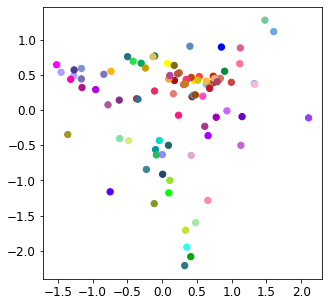

In [21]:
cldf = utils.read_visp_npp_cldf()
vectors = pd.DataFrame(model.embeddings[1].weight.detach().numpy(), index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.columns = ["Z0", "Z1"]
cldf.index = cldf.index.astype(str)
emb = vectors.merge(cldf, on="cluster_id")
fig = plot_utils.plot_embedding(data=emb, plot_dim=2, plot_size=(5,5))

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


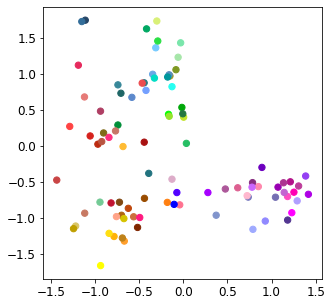

In [22]:
cldf = utils.read_visp_npp_cldf()
vectors = pd.DataFrame(model.embeddings[0].weight.detach().numpy(), index=index_2_word.values())
vectors.index.name = "cluster_id"
vectors.columns = ["Z0", "Z1"]
cldf.index = cldf.index.astype(str)
emb = vectors.merge(cldf, on="cluster_id")
fig = plot_utils.plot_embedding(data=emb, plot_dim=2, plot_size=(5,5))